
<a id='aiyagari'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# The Aiyagari Model

# GPU

This lecture was built using a machine with access to a GPU — although it will also run without one.

[Google Colab](https://colab.research.google.com/) has a free tier with GPUs
that you can access as follows:

1. Click on the “play” icon top right  
1. Select Colab  
1. Set the runtime environment to include a GPU  

## Contents

- [The Aiyagari Model](#The-Aiyagari-Model)  
  - [Overview](#Overview)  
  - [The Economy](#The-Economy)  
  - [Implementation](#Implementation)  
  - [Exercises](#Exercises)  

In addition to what’s included in base Anaconda, we need to install JAX

## Overview

In this lecture, we describe the structure of a class of models that build on work by Truman Bewley [[Bewley, 1977](https://python.quantecon.org/zreferences.html#id191)].

We begin by discussing an example of a Bewley model due to Rao Aiyagari [[Aiyagari, 1994](https://python.quantecon.org/zreferences.html#id155)].

The model features

- heterogeneous agents  
- a single exogenous vehicle for borrowing and lending  
- limits on amounts individual agents may borrow  


The Aiyagari model has been used to investigate many topics, including

- precautionary savings and the effect of liquidity constraints [[Aiyagari, 1994](https://python.quantecon.org/zreferences.html#id155)]  
- risk sharing and asset pricing [[Heaton and Lucas, 1996](https://python.quantecon.org/zreferences.html#id147)]  
- the shape of the wealth distribution [[Benhabib *et al.*, 2015](https://python.quantecon.org/zreferences.html#id148)]  
- etc., etc., etc.  

### Preliminaries

We use the following imports:

In [19]:
import quantecon as qe
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from typing import NamedTuple
from scipy.optimize import bisect

We will use 64-bit floats with JAX in order to increase precision.

In [20]:
jax.config.update("jax_enable_x64", True)

We will use the following function to compute stationary distributions of stochastic matrices (for a reference to the algorithm, see p. 88 of [Economic Dynamics](https://johnstachurski.net/edtc)).

In [21]:
@jax.jit
def compute_stationary(P):
    n = P.shape[0]
    I = jnp.identity(n)
    O = jnp.ones((n, n))
    A = I - jnp.transpose(P) + O
    return jnp.linalg.solve(A, jnp.ones(n))

### References

The primary reference for this lecture is [[Aiyagari, 1994](https://python.quantecon.org/zreferences.html#id155)].

A textbook treatment is available in chapter 18 of [[Ljungqvist and Sargent, 2018](https://python.quantecon.org/zreferences.html#id200)].

A continuous time version of the model by SeHyoun Ahn and Benjamin Moll can be found [here](https://nbviewer.org/github/QuantEcon/QuantEcon.notebooks/blob/master/aiyagari_continuous_time.ipynb).

## The Economy

### Households

Infinitely lived households / consumers face idiosyncratic income shocks.

A unit interval of  *ex-ante* identical households face a common borrowing constraint.

The savings problem faced by a typical  household is

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq -B
$$

where

- $ c_t $ is current consumption  
- $ a_t $ is assets  
- $ z_t $ is an exogenous component of labor income capturing stochastic unemployment risk, etc.  
- $ w $ is a wage rate  
- $ r $ is a net interest rate  
- $ B $ is the maximum amount that the agent is allowed to borrow  


The exogenous process $ \{z_t\} $ follows a finite state Markov chain with given stochastic matrix $ P $.

The wage and interest rate are fixed over time.

In this simple version of the model, households supply labor inelastically because they do not value leisure.

### Firms

Firms produce output by hiring capital and labor.

Firms act competitively and face constant returns to scale.

Since returns to scale are constant, the number of firms does not matter.

Hence we can consider a single (but nonetheless competitive) representative firm.

The firm’s output is

$$
Y = A K^{\alpha} N^{1 - \alpha}
$$

where

- $ A $ and $ \alpha $ are parameters with $ A > 0 $ and $ \alpha \in (0, 1) $  
- $ K $ is aggregate capital  
- $ N $ is total labor supply (which is constant in this simple version of the model)  


The firm’s problem is

$$
\max_{K, N} \left\{ A K^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

The parameter $ \delta $ is the depreciation rate.

These parameters are stored in the following namedtuple:

In [22]:
class Firm(NamedTuple):
    A: float = 1.0    # Total factor productivity
    N: float = 1.0    # Total labor supply
    α: float = 0.33   # Capital share
    δ: float = 0.05   # Depreciation rate

From the first-order condition with respect to capital, the firm’s inverse demand for capital is


<a id='equation-aiy-rgk'></a>
$$
r = A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta \tag{79.1}
$$

In [23]:
def r_given_k(K, firm):
    """
    Inverse demand curve for capital. The interest rate associated with a
    given demand for capital K.
    """
    A, N, α, δ = firm
    return A * α * (N / K)**(1 - α) - δ

Using this expression and the firm’s first-order condition for labor, we can pin down
the equilibrium wage rate as a function of $ r $ as


<a id='equation-aiy-wgr'></a>
$$
w(r) = A  (1 - \alpha)  (A \alpha / (r + \delta))^{\alpha / (1 - \alpha)} \tag{79.2}
$$

In [24]:
def r_to_w(r, firm):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    A, N, α, δ = firm
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

### Equilibrium

We construct  a **stationary rational expectations equilibrium (SREE)**.

In such an equilibrium

- prices induce behavior that generates aggregate quantities consistent with the prices  
- aggregate quantities and prices are constant over time  


In more detail, an SREE lists a set of prices, savings and production policies such that

- households want to choose the specified savings policies taking the prices as given  
- firms maximize profits taking the same prices as given  
- the resulting aggregate quantities are consistent with the prices; in particular, the demand for capital equals the supply  
- aggregate quantities (defined as cross-sectional averages) are constant  

## Implementation

Let’s look at how we might compute such an equilibrium in practice.

Below we provide code to solve the household problem, taking $ r $ and $ w $ as fixed.

### Primitives and operators

We will solve the household problem using value function iteration.

First we set up a `NamedTuple` to store the parameters that define a household asset accumulation problem, as well as the grids used to solve it

In [25]:
class Household(NamedTuple):
    β: float            # Discount factor
    a_grid: jnp.ndarray # Asset grid
    z_grid: jnp.ndarray # Exogenous states
    Π: jnp.ndarray      # Transition matrix

def create_household(β=0.96,                      # Discount factor
                     Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                     z_grid=[0.1, 1.0],           # Exogenous states
                     a_min=1e-10, a_max=12.5,     # Asset grid
                     a_size=100):
    """
    Create a Household namedtuple with custom grids.
    """
    a_grid = jnp.linspace(a_min, a_max, a_size)
    z_grid, Π = map(jnp.array, (z_grid, Π))
    return Household(β=β, a_grid=a_grid, z_grid=z_grid, Π=Π)

For now we assume that $ u(c) = \log(c) $

In [26]:
u = jnp.log

Here’s a namedtuple that stores the wage rate and interest rate with default values

In [27]:
class Prices(NamedTuple):
    r: float = 0.01  # Interest rate
    w: float = 1.0   # Wages

Now we set up a vectorized version of the right-hand side of the Bellman equation (before maximization), which is a 3D array representing

$$
B(a, z, a') = u(wz + (1+r)a - a') + \beta \sum_{z'} v(a', z') \Pi(z, z')
$$

for all $ (a, z, a') $.

In [28]:
def B(v, household, prices):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute current consumption as array c[i, j, ip]
    a  = jnp.reshape(a_grid, (a_size, 1, 1))    # a[i]   ->  a[i, j, ip]
    z  = jnp.reshape(z_grid, (1, z_size, 1))    # z[j]   ->  z[i, j, ip]
    ap = jnp.reshape(a_grid, (1, 1, a_size))    # ap[ip] -> ap[i, j, ip]
    c = w * z + (1 + r) * a - ap

    # Calculate continuation rewards at all combinations of (a, z, ap)
    v = jnp.reshape(v, (1, 1, a_size, z_size)) # v[ip, jp] -> v[i, j, ip, jp]
    Π = jnp.reshape(Π, (1, z_size, 1, z_size)) # Π[j, jp]  -> Π[i, j, ip, jp]
    EV = jnp.sum(v * Π, axis=-1)               # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, u(c) + β * EV, -jnp.inf)

The next function computes greedy policies

In [29]:
def get_greedy(v, household, prices):
    """
    Computes a v-greedy policy σ, returned as a set of indices. If
    σ[i, j] equals ip, then a_grid[ip] is the maximizer at i, j.
    """
    # argmax over ap
    return jnp.argmax(B(v, household, prices), axis=-1)

We define the Bellman operator $ T $, which takes a value function $ v $ and returns $ Tv $ as given in the Bellman equation

In [30]:
def T(v, household, prices):
    """
    The Bellman operator. Takes a value function v and returns Tv.
    """
    return jnp.max(B(v, household, prices), axis=-1)

Here’s value function iteration, which repeatedly applies the Bellman operator until convergence

In [31]:
@jax.jit
def value_function_iteration(household, prices, tol=1e-4, max_iter=10_000):
    """
    Implements value function iteration using a compiled JAX loop.
    """
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    def condition_function(loop_state):
        i, v, error = loop_state
        return jnp.logical_and(error > tol, i < max_iter)

    def update(loop_state):
        i, v, error = loop_state
        v_new = T(v, household, prices)
        error = jnp.max(jnp.abs(v_new - v))
        return i + 1, v_new, error

    # Initial loop state
    v_init = jnp.zeros((a_size, z_size))
    loop_state_init = (0, v_init, tol + 1)

    # Run the fixed point iteration
    i, v, error = jax.lax.while_loop(condition_function, update, loop_state_init)

    return get_greedy(v, household, prices)

As a first example of what we can do, let’s compute and plot an optimal accumulation policy at fixed prices

In [32]:
# Create an instance of Household
household = create_household()
prices = Prices()

r, w = prices
print(f"Interest rate: {r}, Wage: {w}")

Interest rate: 0.01, Wage: 1.0


In [33]:
with qe.Timer():
    σ_star = value_function_iteration(household, prices).block_until_ready()

0.08 seconds elapsed


The next plot shows asset accumulation policies at different values of the exogenous state

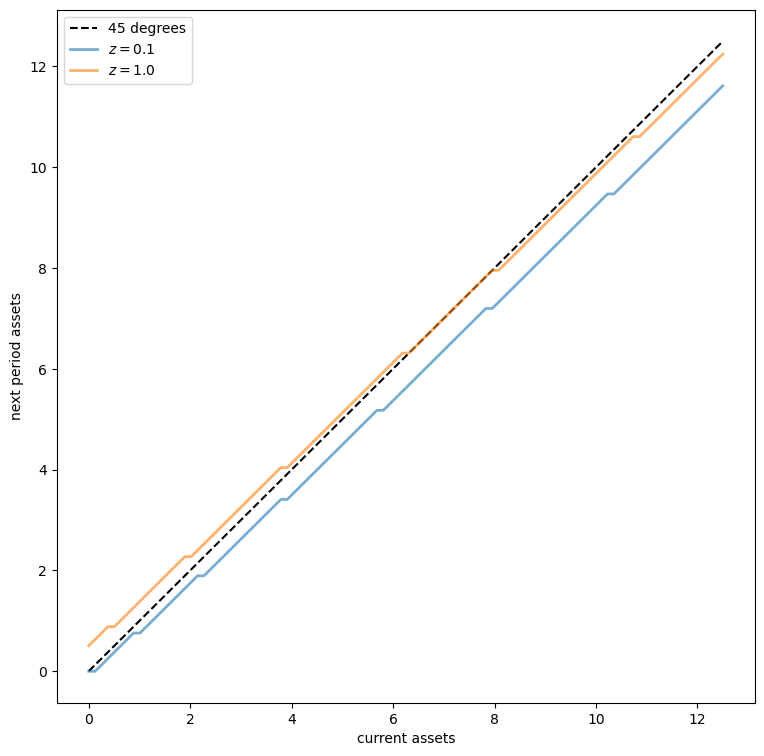

In [34]:
β, a_grid, z_grid, Π = household

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_grid, a_grid, 'k--', label="45 degrees")  
for j, z in enumerate(z_grid):
    lb = f'$z = {z:.2}$'
    policy_vals = a_grid[σ_star[:, j]]
    ax.plot(a_grid, policy_vals, lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')
plt.show()

The plot shows asset accumulation policies at different values of the exogenous state.

### Capital supply

To start thinking about equilibrium, we need to know how much capital households supply at a given interest rate $ r $.

This quantity can be calculated by taking the stationary distribution of assets under the optimal policy and computing the mean.

The next function computes the stationary distribution for a given policy $ \sigma $ via the following steps:

- Compute the stationary distribution $ \psi = (\psi(a, z)) $ of $ P_{\sigma} $, which defines the Markov chain of the state $ (a_t, z_t) $ under policy $ \sigma $.  
- Sum out $ z_t $ to get the marginal distribution for $ a_t $.  

In [35]:
@jax.jit
def compute_asset_stationary(σ, household):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Construct P_σ as an array of the form P_σ[i, j, ip, jp]
    ap_idx = jnp.arange(a_size)
    ap_idx = jnp.reshape(ap_idx, (1, 1, a_size, 1))
    σ = jnp.reshape(σ, (a_size, z_size, 1, 1))
    A = jnp.where(σ == ap_idx, 1, 0)
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))
    P_σ = A * Π

    # Reshape P_σ into a matrix
    n = a_size * z_size
    P_σ = jnp.reshape(P_σ, (n, n))

    # Get stationary distribution and reshape back onto [i, j] grid
    ψ = compute_stationary(P_σ)
    ψ = jnp.reshape(ψ, (a_size, z_size))

    # Sum along the rows to get the marginal distribution of assets
    ψ_a = jnp.sum(ψ, axis=1)
    return ψ_a

Let’s give this a test run.

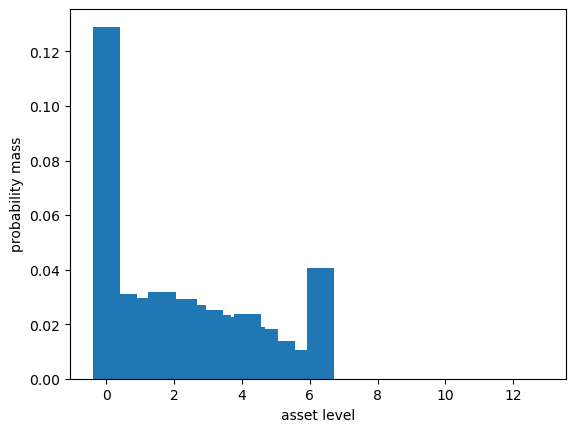

In [36]:
ψ_a = compute_asset_stationary(σ_star, household)

fig, ax = plt.subplots()
ax.bar(household.a_grid, ψ_a)
ax.set_xlabel("asset level")
ax.set_ylabel("probability mass")
plt.show()

The distribution should sum to one:

In [37]:
ψ_a.sum()

Array(1., dtype=float64)

The next function computes aggregate capital supply by households under policy $ \sigma $, given wages and interest rates

In [38]:
def capital_supply(σ, household):
    """
    Induced level of capital stock under the policy, taking r and w as given.
    """
    β, a_grid, z_grid, Π = household
    ψ_a = compute_asset_stationary(σ, household)
    return float(jnp.sum(ψ_a * a_grid))

### Equilibrium

We compute a SREE as follows:

1. Set $ n=0 $ and start with an initial guess $ K_0 $ for aggregate capital.  
1. Determine prices $ r, w $ from the firm decision problem, given $ K_n $.  
1. Compute the optimal savings policy of households given these prices.  
1. Compute aggregate capital $ K_{n+1} $ as the mean of steady-state capital given this savings policy.  
1. If $ K_{n+1} \approx K_n $, stop; otherwise, go to step 2.  


We can write the sequence of operations in steps 2-4 as

$$
K_{n + 1} = G(K_n)
$$

If $ K_{n+1} $ agrees with $ K_n $ then we have a SREE.

In other words, our problem is to find the fixed point of the one-dimensional map $ G $.

Here’s $ G $ expressed as a Python function

In [39]:
def G(K, firm, household):
    # Get prices r, w associated with K
    r = r_given_k(K, firm)
    w = r_to_w(r, firm)

    # Generate a household object with these prices, compute
    # aggregate capital.
    prices = Prices(r=r, w=w)
    σ_star = value_function_iteration(household, prices)
    return capital_supply(σ_star, household)

Let’s inspect visually as a first pass

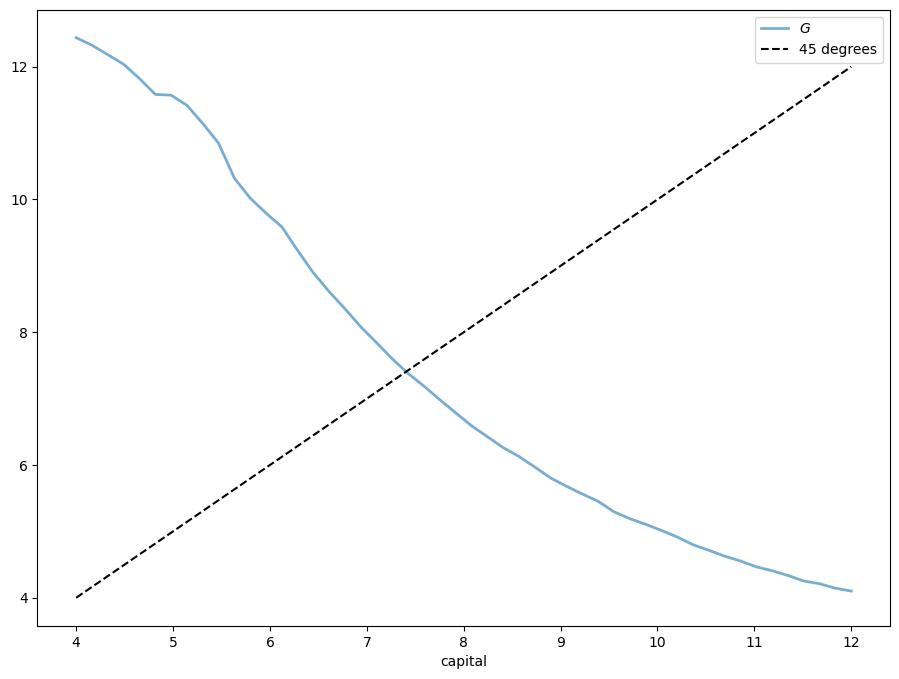

In [40]:
num_points = 50
firm = Firm()
household = create_household()
k_vals = jnp.linspace(4, 12, num_points)
out = [G(k, firm, household) for k in k_vals]

fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, out, lw=2, alpha=0.6, label='$G$')
ax.plot(k_vals, k_vals, 'k--', label="45 degrees")
ax.set_xlabel('capital')
ax.legend()
plt.show()

Now let’s compute the equilibrium.

Looking at the figure above, we see that a simple iteration scheme $ K_{n+1} = G(K_n) $ will cycle from high to low values, leading to slow convergence.

As a result, we use a damped iteration scheme of the form

$$
K_{n+1} = \alpha K_n + (1-\alpha) G(K_n)
$$

In [41]:
def compute_equilibrium(firm, household,
                        K0=6, α=0.99, max_iter=1_000, tol=1e-4, 
                        print_skip=10, verbose=False):
    n = 0
    K = K0
    error = tol + 1
    while error > tol and n < max_iter:
        new_K = α * K + (1 - α) * G(K, firm, household)
        error = abs(new_K - K)
        K = new_K
        n += 1
        if verbose and n % print_skip == 0:
            print(f"At iteration {n} with error {error}")
    return K, n

In [42]:
firm = Firm()
household = create_household()
print("\nComputing equilibrium capital stock")
with qe.Timer():
    K_star, n = compute_equilibrium(firm, household, K0=6.0)
print(f"Computed equilibrium {K_star:.5} in {n} iterations")


Computing equilibrium capital stock
1.31 seconds elapsed
Computed equilibrium 7.4095 in 259 iterations


This convergence is not very fast, given how quickly we can solve the household problem.

You can try varying $ \alpha $, but usually this parameter is hard to set a priori.

In the exercises below you will be asked to use bisection instead, which generally performs better.

### Supply and demand curves

We can visualize the equilibrium using supply and demand curves.

The following code draws the aggregate supply and demand curves.

The intersection gives the equilibrium interest rate and capital

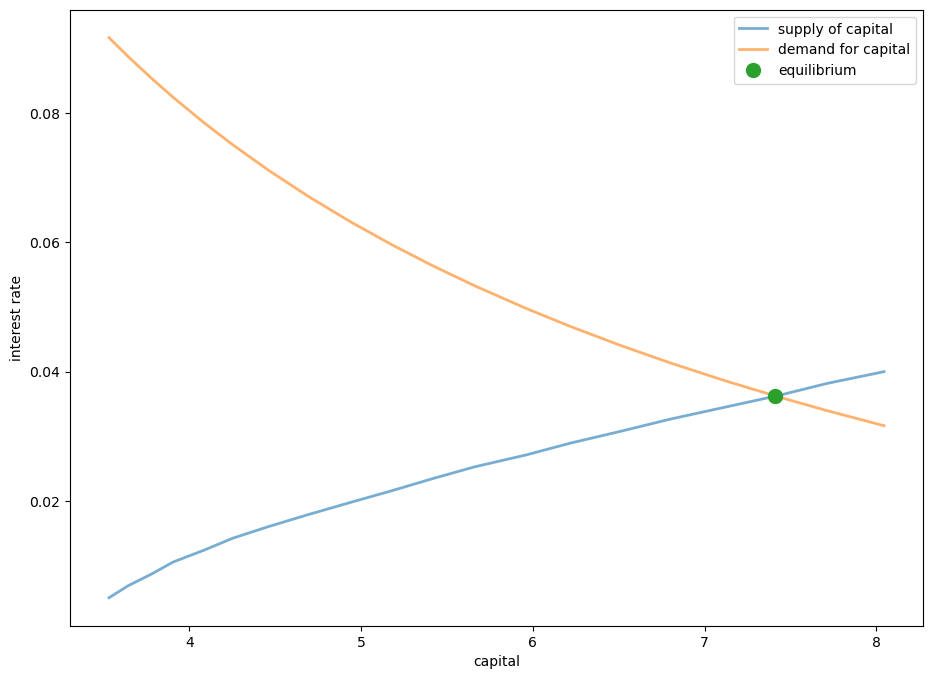

In [43]:
def prices_to_capital_stock(household, r, firm):
    """
    Map prices to the induced level of capital stock.
    """
    w = r_to_w(r, firm)
    prices = Prices(r=r, w=w)

    # Compute the optimal policy
    σ_star = value_function_iteration(household, prices)

    # Compute capital supply
    return capital_supply(σ_star, household)

# Create a grid of r values to compute demand and supply of capital
num_points = 20
r_vals = jnp.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = []
for r in r_vals:
    k_vals.append(prices_to_capital_stock(household, r, firm))

# Plot against demand for capital by firms
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, 
        label='supply of capital')
ax.plot(k_vals, r_given_k(
        jnp.array(k_vals), firm), lw=2, alpha=0.6, 
        label='demand for capital')

# Add marker at equilibrium
r_star = r_given_k(K_star, firm)
ax.plot(K_star, r_star, 'o', markersize=10, label='equilibrium')

ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()

## Exercises

## Exercise 79.1

Write a new version of `compute_equilibrium` that uses `bisect` from `scipy.optimize` instead of damped iteration.

See if you can make it faster than the previous version.

In `bisect`,

- you should set `xtol=1e-4` to have the same error tolerance as the previous version.  
- for the lower and upper bounds of the bisection routine try `a = 1.0` and `b = 20.0`.  

## Solution

We use bisection to find the zero of the function $ h(k) = k - G(k) $

In [44]:
def compute_equilibrium_bisect(firm, household, a=1.0, b=20.0):
    K = bisect(lambda k: k - G(k, firm, household), a, b, xtol=1e-4)
    return K

firm = Firm()
household = create_household()
print("\nComputing equilibrium capital stock using bisection")
with qe.Timer():
    K_star = compute_equilibrium_bisect(firm, household)
print(f"Computed equilibrium capital stock {K_star:.5}")


Computing equilibrium capital stock using bisection
0.09 seconds elapsed
Computed equilibrium capital stock 7.4178


The bisection method is faster than the damped iteration scheme.

## Exercise 79.2

Show how equilibrium capital stock changes with $ \beta $.

Use the following values of $ \beta $ and plot the relationship you find.

In [45]:
β_vals = jnp.linspace(0.94, 0.98, 20)

## Solution

Computed equilibrium 5.897 at β = 0.94
Computed equilibrium 6.052 at β = 0.9421052631578948
Computed equilibrium 6.202 at β = 0.9442105263157894
Computed equilibrium 6.36 at β = 0.9463157894736841
Computed equilibrium 6.524 at β = 0.9484210526315789
Computed equilibrium 6.679 at β = 0.9505263157894738
Computed equilibrium 6.85 at β = 0.9526315789473684
Computed equilibrium 7.008 at β = 0.9547368421052631
Computed equilibrium 7.16 at β = 0.9568421052631579
Computed equilibrium 7.325 at β = 0.9589473684210527
Computed equilibrium 7.486 at β = 0.9610526315789474
Computed equilibrium 7.657 at β = 0.963157894736842
Computed equilibrium 7.81 at β = 0.9652631578947368
Computed equilibrium 7.967 at β = 0.9673684210526317
Computed equilibrium 8.142 at β = 0.9694736842105263
Computed equilibrium 8.302 at β = 0.971578947368421
Computed equilibrium 8.463 at β = 0.9736842105263158
Computed equilibrium 8.616 at β = 0.9757894736842105
Computed equilibrium 8.773 at β = 0.9778947368421053
Computed equi

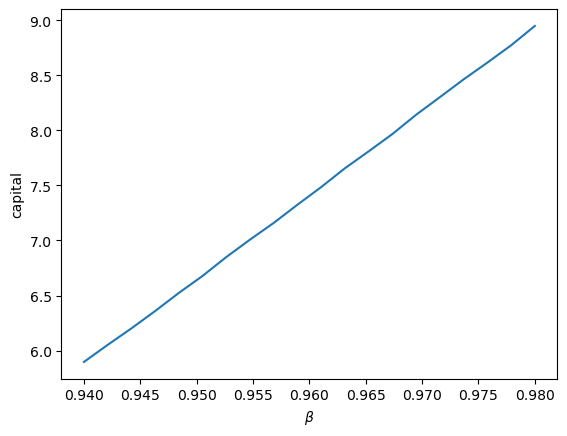

In [46]:
K_vals = []
K = 6.0  # initial guess

for β in β_vals:
    household = create_household(β=β)
    K = compute_equilibrium_bisect(firm, household, 0.5 * K, 1.5 * K)
    print(f"Computed equilibrium {K:.4} at β = {β}")
    K_vals.append(K)

fig, ax = plt.subplots()
ax.plot(β_vals, K_vals, ms=2)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('capital')
plt.show()

## Exercise 79.3

In this lecture, we used value function iteration to solve the household problem.

An alternative is Howard policy iteration (HPI), which is discussed in detail in [Dynamic Programming](https://dp.quantecon.org/).

HPI can be faster than VFI for some problems because it uses fewer but more computationally intensive iterations.

Your task is to implement Howard policy iteration and compare the results with value function iteration.

**Key concepts you’ll need:**

Howard policy iteration requires computing the value $ v_{\sigma} $ of a policy $ \sigma $, defined as:

$$
v_{\sigma} = (I - \beta P_{\sigma})^{-1} r_{\sigma}
$$

where $ r_{\sigma} $ is the reward vector under policy $ \sigma $, and $ P_{\sigma} $ is the transition matrix induced by $ \sigma $.

To solve this, you’ll need to:

1. Compute current rewards $ r_{\sigma}(a, z) = u((1 + r)a + wz - \sigma(a, z)) $  
1. Set up the linear operator $ R_{\sigma} $ where $ (R_{\sigma} v)(a, z) = v(a, z) - \beta \sum_{z'} v(\sigma(a, z), z') \Pi(z, z') $  
1. Solve $ v_{\sigma} = R_{\sigma}^{-1} r_{\sigma} $ using `jax.scipy.sparse.linalg.bicgstab`  


You can use the `get_greedy` function that’s already defined in this lecture.

Implement the following Howard policy iteration routine:

In [47]:
def howard_policy_iteration(household, prices,
                            tol=1e-4, max_iter=10_000, verbose=False):
    """
    Howard policy iteration routine.
    """
    # Your code here
    pass

Once implemented, compute the equilibrium capital stock using HPI and verify that it produces approximately the same result as VFI at the default parameter values.

## Solution

First, we need to implement the helper functions for Howard policy iteration.

The following function computes the array $ r_{\sigma} $ which gives current rewards given policy $ \sigma $:

In [48]:
def compute_r_σ(σ, household, prices):
    """
    Compute current rewards at each i, j under policy σ. In particular,

        r_σ[i, j] = u((1 + r)a[i] + wz[j] - a'[ip])

    when ip = σ[i, j].
    """
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute r_σ[i, j]
    a = jnp.reshape(a_grid, (a_size, 1))
    z = jnp.reshape(z_grid, (1, z_size))
    ap = a_grid[σ]
    c = (1 + r) * a + w * z - ap
    r_σ = u(c)

    return r_σ

The linear operator $ R_{\sigma} $ is defined as:

In [49]:
def R_σ(v, σ, household):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (a_size, z_size, 1))
    V = v[σ, zp_idx]

    # Expand Π[j, jp] to Π[i, j, jp]
    Π = jnp.reshape(Π, (1, z_size, z_size))

    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Π[j, jp]
    return v - β * jnp.sum(V * Π, axis=-1)

The next function computes the lifetime value of a given policy:

In [50]:
def get_value(σ, household, prices):
    """
    Get the lifetime value of policy σ by computing

        v_σ = R_σ^{-1} r_σ
    """
    r_σ = compute_r_σ(σ, household, prices)

    # Reduce R_σ to a function in v
    _R_σ = lambda v: R_σ(v, σ, household)

    # Compute v_σ = R_σ^{-1} r_σ using an iterative routine.
    return jax.scipy.sparse.linalg.bicgstab(_R_σ, r_σ)[0]

Now we can implement Howard policy iteration:

In [51]:
@jax.jit
def howard_policy_iteration(household, prices, tol=1e-4, max_iter=10_000):
    """
    Howard policy iteration routine using a compiled JAX loop.
    """
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    def condition_function(loop_state):
        i, σ, v_σ, error = loop_state
        return jnp.logical_and(error > tol, i < max_iter)

    def update(loop_state):
        i, σ, v_σ, error = loop_state
        σ_new = get_greedy(v_σ, household, prices)
        v_σ_new = get_value(σ_new, household, prices)
        error = jnp.max(jnp.abs(v_σ_new - v_σ))
        return i + 1, σ_new, v_σ_new, error

    # Initial loop state
    σ_init = jnp.zeros((a_size, z_size), dtype=int)
    v_σ_init = get_value(σ_init, household, prices)
    loop_state_init = (0, σ_init, v_σ_init, tol + 1)

    # Run the fixed point iteration
    i, σ, v_σ, error = jax.lax.while_loop(condition_function, update, loop_state_init)

    return σ

Now let’s create a modified version of the G function that uses HPI:

In [52]:
def G_hpi(K, firm, household):
    # Get prices r, w associated with K
    r = r_given_k(K, firm)
    w = r_to_w(r, firm)

    # Generate prices and compute aggregate capital using HPI.
    prices = Prices(r=r, w=w)
    σ_star = howard_policy_iteration(household, prices)
    return capital_supply(σ_star, household)

And compute the equilibrium using HPI:

In [53]:
def compute_equilibrium_bisect_hpi(firm, household, a=1.0, b=20.0):
    K = bisect(lambda k: k - G_hpi(k, firm, household), a, b, xtol=1e-4)
    return K

firm = Firm()
household = create_household()
print("\nComputing equilibrium capital stock using HPI")
with qe.Timer():
    K_star_hpi = compute_equilibrium_bisect_hpi(firm, household)
print(f"Computed equilibrium capital stock with HPI: {K_star_hpi:.5}")
print(f"Previous equilibrium capital stock with VFI: {K_star:.5}")
print(f"Difference: {abs(K_star_hpi - K_star):.6}")


Computing equilibrium capital stock using HPI
0.26 seconds elapsed
Computed equilibrium capital stock with HPI: 7.4172
Previous equilibrium capital stock with VFI: 7.4178
Difference: 0.000579834


The results show that both methods produce approximately the same equilibrium, confirming that HPI is a valid alternative to VFI.